This notebook is structured to read levels from an xml and perform sample calculations. We start off by installing any missing packages this notebook will need to fully run.

In [1]:
import sys, subprocess, pkg_resources
required = {'numpy','lvlspy','matplotlib', 'scipy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed
if missing:
    subprocess.check_call([sys.executable, '-m','pip','install','--quiet',*missing])


import numpy as np
from scipy.integrate import odeint
import lvlspy.level as lv
import lvlspy.spcoll as lc
import lvlspy.species as ls
import lvlspy.transition as lt
import matplotlib.pyplot as plt

Now download an example xml file, called, appropriately enough, *example.xml*, from [OSF](https://osf.io/3f59u/).  You may instead place or upload your own file and use it by commenting out the *curl* command.

In [2]:
!curl -o example.xml -J -L https://osf.io/w6ndg/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1358      0 --:--:-- --:--:-- --:--:--  1447
100  2633  100  2633    0     0   1395      0  0:00:01  0:00:01 --:--:--  7654


Begin by creating a new species collection.

In [3]:
new_coll = lc.SpColl()

Now ensure that the data in *example.xml* are appropriate to use with *lvlspy* by validating the XML file against the appropriate liblvls schema.

In [4]:
new_coll.validate('example.xml')

Now read the data into the species collection by updating the (empty) collection with data from the XML file.

In [5]:
new_coll.update_from_xml('example.xml')

Let's extract the species from the collection and set a temperature (in Kelvin)

In [6]:
sp = new_coll.get()['my_species']
T = 1.e9 #K

From the stored properties in the xml, energies, Einstein A coefficients, and multiplicities, with the supplied temperature, we can calculate the rate matrix

In [7]:
rate_matrix = sp.compute_rate_matrix(T)

print('\nRate Matrix:\n')

for i in range(rate_matrix.shape[0]):
    for j in range(rate_matrix.shape[1]):
        print(i, j, rate_matrix[i, j])


Rate Matrix:

0 0 -99.61520922412008
0 1 145.63353766999222
0 2 110.88749726829367
0 3 103.17423799887672
0 4 100.30298949477434
1 0 45.633537669992236
1 1 -363.7504249198252
1 2 145.63353766999222
1 3 110.88749726829367
1 4 100.973414921661
2 0 43.549989073174686
2 1 182.53415067996895
2 2 -293.1268666899376
2 3 145.63353766999222
2 4 103.17423799887672
3 0 9.522713996630143
3 1 32.66249180488102
3 2 34.22515325249418
3 3 -370.58277020545626
3 4 110.88749726829367
4 0 0.9089684843230127
4 1 2.9202447649830314
4 2 2.380678499157536
4 3 10.887497268293671
4 4 -415.33813968360573


The following exercises can be done by going through the steps of the other notebook without having to import an xml, but for the sake of flexing the power of the API, this is the route we chose. Since we have a rate matrix, we can now evolve our species with time at a fixed temperature. The governing differential equation is $\frac{dY}{dt} = \Lambda Y$. We solve this with an integrator.

Set up the beginning and end times and the number of time steps to integrate over.

In [8]:
t_begin = 1.e-30
t_end = 100
n_steps = 2000

Now create the time array from those inputs.  Insert zero at the beginning.

In [9]:
t = np.logspace(np.log10(t_begin), np.log10(t_end), n_steps)

Define the routine to compute the derivatives.

In [10]:
def my_func(y, t, rate_matrix):
    return rate_matrix.dot(y)

Now solve the coupled equations with an exponential solver.  First, set the initial probability vector (here with all probability in the first state initially).  Then create a sparse matrix version of the rate matrix and solve.

In [11]:
y = np.zeros(rate_matrix.shape[0])
y[0] = 1

sol = odeint(my_func, y, t, args=(rate_matrix,))

Before plotting the solution, we can also compute the equilibrium solution beforehand and see if our evolved solutions will tend to them.

In [12]:
eq_probs = sp.compute_equilibrium_probabilities(T)

Now plot the probability evolution and equilibrium (as *x*'s).

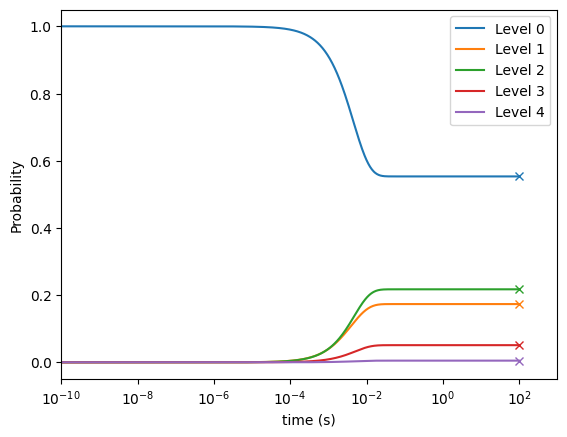

In [13]:
for i in range(sol.shape[1]):
    plt.plot(t, sol[:, i], label = 'Level ' + str(i))
    
plt.gca().set_prop_cycle(None)  # Reset the color cycle to align equilibria with network solutions.

for i in range(sol.shape[1]):
    plt.plot(t[t.shape[0]-1], eq_probs[i], 'x')
    
plt.xscale('log')
plt.xlim([1.e-10, 1000])
plt.xlabel('time (s)')
plt.ylabel('Probability')
plt.legend()

The fugacity evolution of each level can be calculated based on the attained solution

Text(0, 0.5, 'Fugacity')

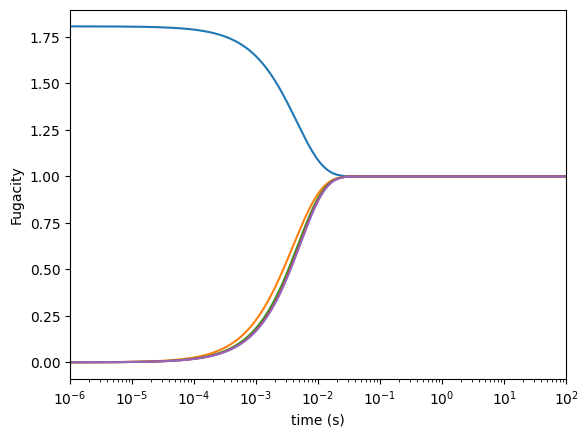

In [14]:
fugacities = np.empty((sol.shape[0], sol.shape[1]))

for i in range(len(sp.get_levels())):
    fugacities[:, i] = sol[:, i] / eq_probs[i]
    
for i in range(len(sp.get_levels())):
    plt.plot(t, fugacities[:, i], label = str(i) + ' level')
    
plt.xscale('log')
plt.xlim([1.e-6, 100])
plt.xlabel('time (s)')
plt.ylabel('Fugacity')

As a final step to illustrate another *SpColl* method, output the data in the species collection to new files.  The first uses the default energy scale (*keV*) while the second specifically selects *eV* as the energy scale for the levels.

In [15]:
new_coll.write_to_xml("new_example.xml")

new_coll.write_to_xml("new_example_ev.xml", units = 'eV')

!cat new_example_ev.xml

<species_collection>
  <species name="my_species">
    <levels>
      <level>
        <properties>
          <energy units="eV">0.0</energy>
          <multiplicity>1</multiplicity>
        </properties>
      </level>
      <level>
        <properties>
          <energy units="eV">100000.0</energy>
          <multiplicity>1</multiplicity>
        </properties>
        <transitions>
          <transition>
            <to_energy units="eV">0.0</to_energy>
            <to_multiplicity>1</to_multiplicity>
            <a>100.0</a>
          </transition>
        </transitions>
      </level>
      <level>
        <properties>
          <energy units="eV">200000.0</energy>
          <multiplicity>4</multiplicity>
        </properties>
        <transitions>
          <transition>
            <to_energy units="eV">100000.0</to_energy>
            <to_multiplicity>1</to_multiplicity>
            <a>100.0</a>
          </transition>
          <transition>
            <to_energy units="eV">0.0</